In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf,read_raw_edf,read_raw_gdf,read_raw_fif
from mne.datasets import eegbci
from mne.decoding import CSP

In [6]:
def get_data():
    #path = "dataset\\bci_dataset\\train"
    #2b path 
    path = "dataset\\2b_moabb\\train"
    test_path = "dataset\\2b_moabb\\train\\0-raw.fif"
    files = os.listdir(path)
    data_path = []
    for f in files:
        file = os.path.join(path,f)
        data_path.append(file)
        
    
    tmin, tmax = -0.2, 0.4
    event_id = dict(left=1, right = 2)

    raw = concatenate_raws([read_raw_fif(f, preload=True) for f in data_path])
    #raw = concatenate_raws([read_raw_fif(path, preload=True)])
    raw_data = raw.copy()
    print(raw_data.info)
    # strip channel names of "." characters
    raw_data.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    #skip_by_annotation='edge'
    raw_data.filter(l_freq=0.5, h_freq=None)
    raw_data.notch_filter(50)

    events, _ = events_from_annotations(raw_data)
    print(events)
    
    
    picks = pick_types(raw_data.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    print(picks)
    #delete eog band
    #picks = np.delete(picks,[3,4,5])
    
    # Read epochs (train will be done only between 1 and 2s)
    #reject_criteria = dict( eeg=100e-6)       # 100 µV
    # Testing will be done with a running classifier
    epochs = Epochs(raw_data, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None,preload=True)
    #epochs.crop(tmin=1., tmax=None)
    labels = epochs.events[:, 2] - 1
    return epochs.get_data()[:, :, :256], labels,epochs,raw_data


epochs_data, labels,epochs1,raw= get_data()

Opening raw data file dataset\2b_moabb\train\0-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\1-raw.fif...
    Range : 0 ... 552451 =      0.000 ...  2209.804 secs
Ready.
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...
Opening raw data file dataset\2b_moabb\train\10-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\11-raw.fif...
    Range : 0 ... 604802 =      0.000 ...  2419.208 secs
Ready.
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Opening raw data file dataset\2b_moabb\train\12-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  1858.696 secs
Ready.
Reading 0 ... 464674  =      0.000 ...  1858.696 secs...
Opening raw data file dataset\2b_moabb\train\13-raw.fif...
    Range : 0 ... 464674 =      0.000 ...  

In [7]:
# 280 events(epoch)
# 22 channel
# 256 Time(samples)

print(epochs_data.shape)
print(labels.shape)
print(epochs_data.shape[1])
print(labels)
print(raw.info['ch_names'])


(6520, 3, 151)
(6520,)
3
[0 1 0 ... 0 1 0]
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


<Epochs |  6520 events (all good), -0.2 - 0.4 sec, baseline off, ~22.5 MB, data loaded,
 'left': 3260
 'right': 3260>
Using matplotlib as 2D backend.


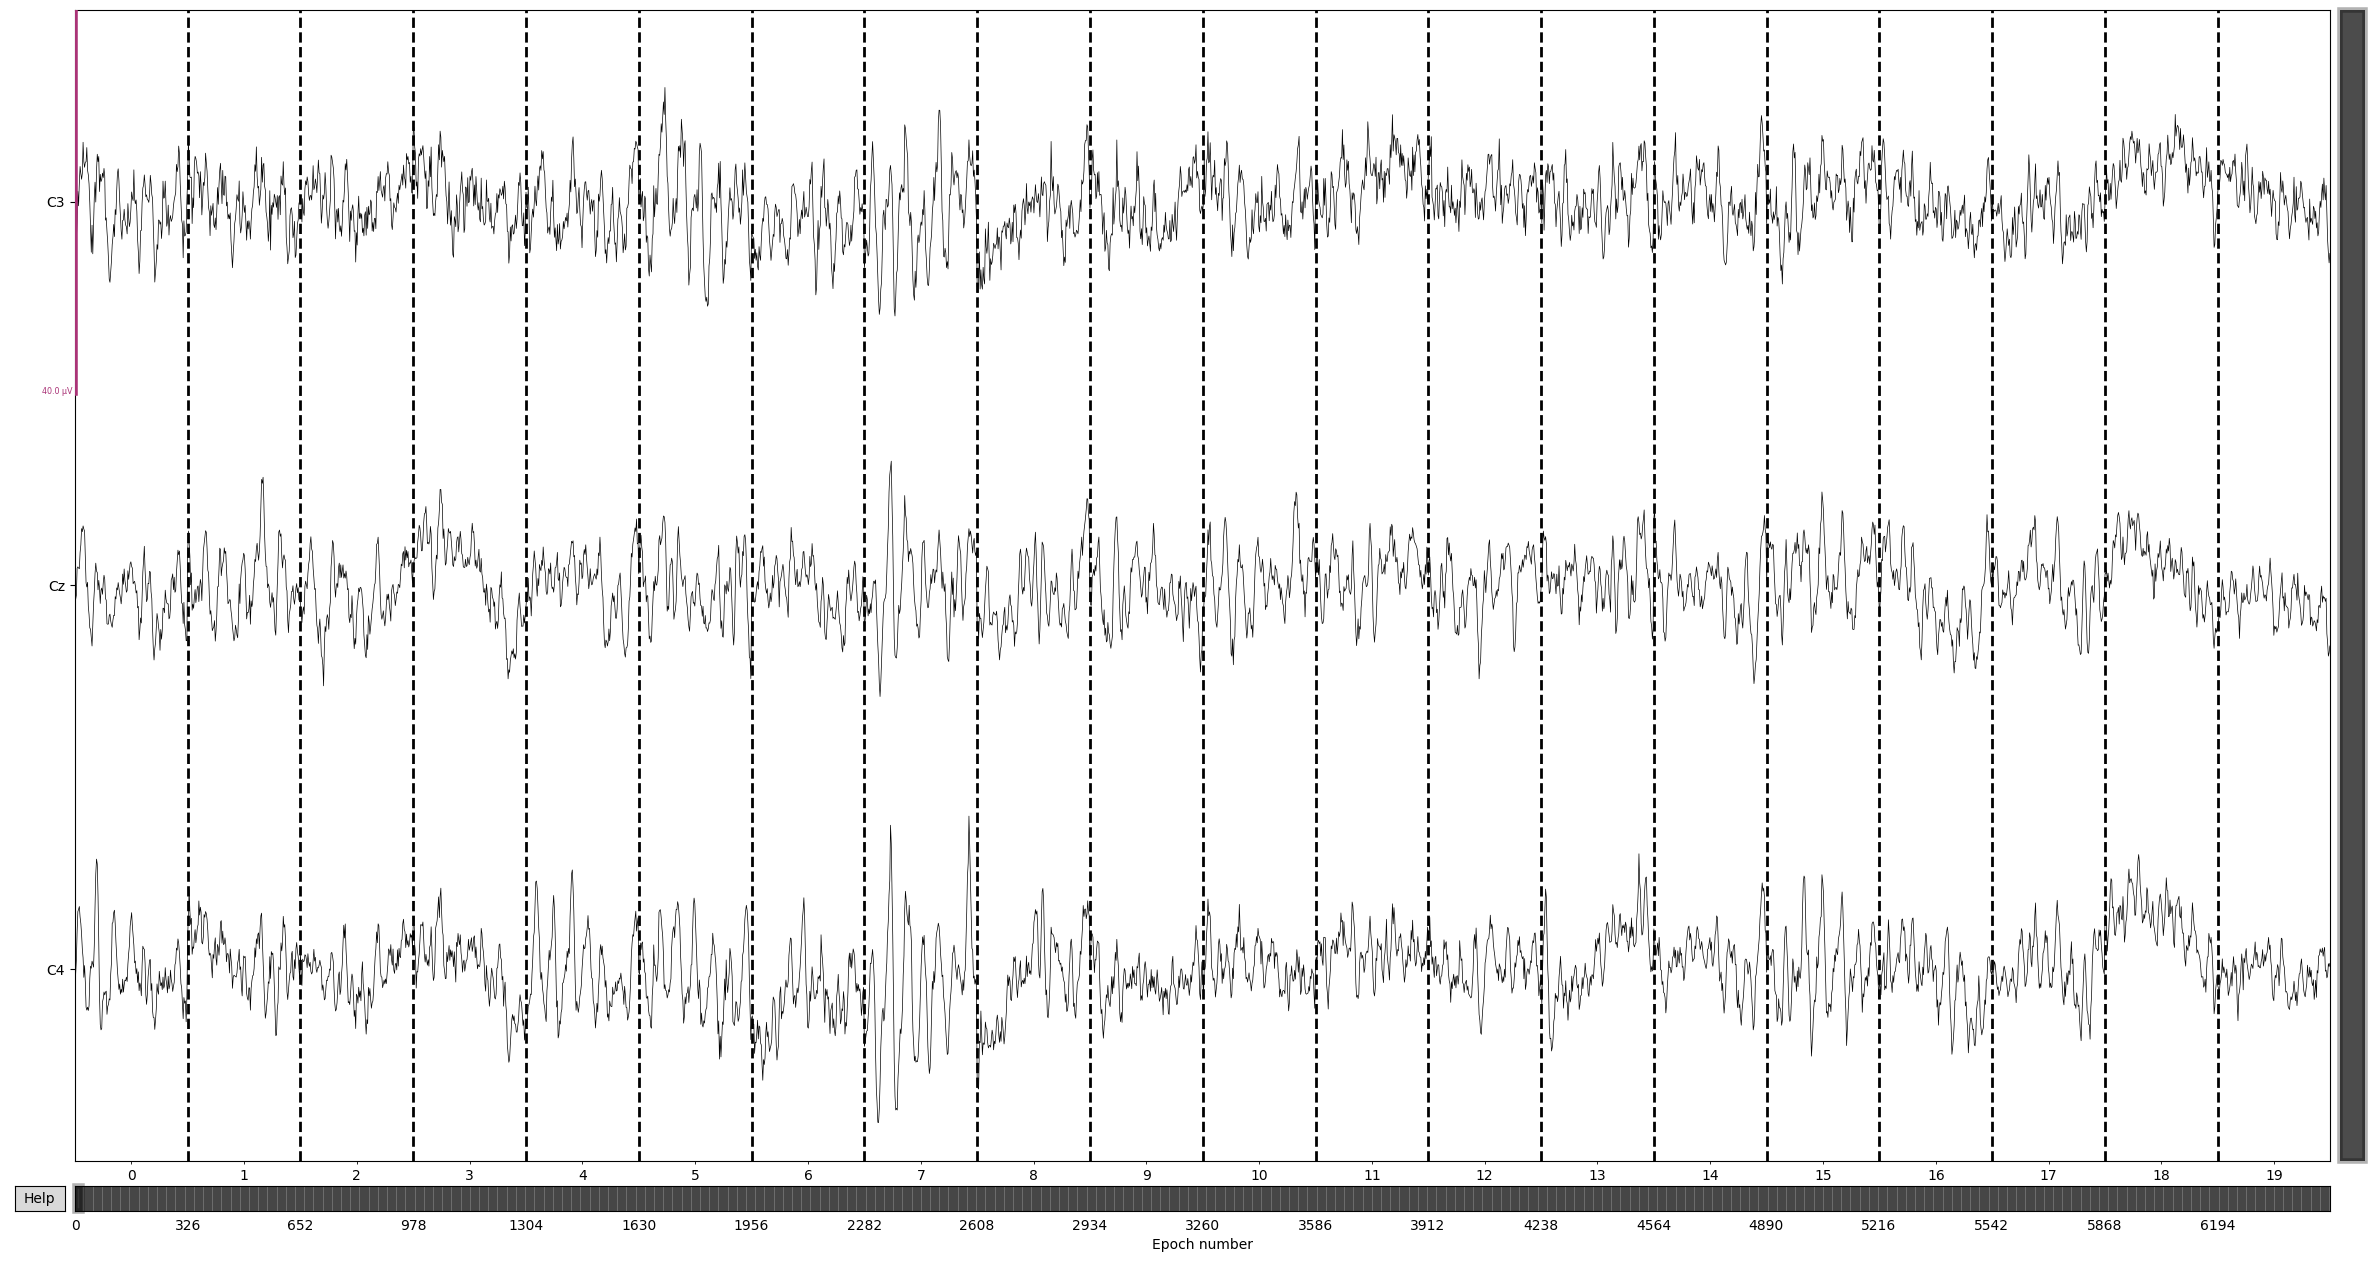

    Using multitaper spectrum estimation with 7 DPSS windows


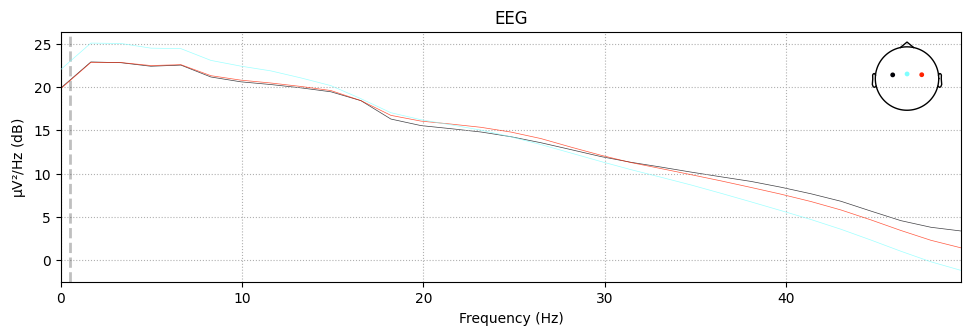

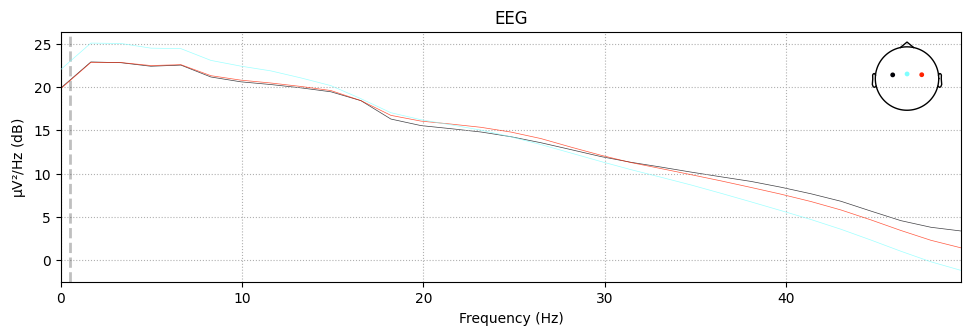

In [8]:
print(epochs1)
epochs1.plot()
epochs1.plot_psd(fmax=50)

In [5]:
def amplitude(x):
    """Data augmentation for adding noise to amplitude of sepctral image
    1 electrode คือ การดึงค่าคลื่นจาก electrode นั้นมา ซึ้่ง electrode นั้นคือ fc fz c4 c3 ประมาณนี้
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        reconstructed new time series from inverse STFT
    """
    print("Hello")



In [9]:
import torch   
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
from torch.utils.data import Subset  
from torch import nn  
import torch.nn.functional as F  
from torch.utils.data import RandomSampler  
from torch.utils.data import SequentialSampler  

from common import EpochsDataset  

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data)
train_idx, test_idx = next(cv_split)


def scale(X):
    """Standard scaling of data along the last dimention.
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    return X / 2e-5

dataset = EpochsDataset(epochs_data, labels, transform=scale)

ds_train, ds_valid = Subset(dataset, train_idx), Subset(dataset, test_idx)

batch_size_train = len(ds_train)
batch_size_valid = len(ds_valid)
sampler_train = RandomSampler(ds_train)
sampler_valid = SequentialSampler(ds_valid)

# create loaders
num_workers = 0
loader_train = \
    DataLoader(ds_train, batch_size=batch_size_train,
               num_workers=num_workers, sampler=sampler_train)
loader_valid = \
    DataLoader(ds_valid, batch_size=batch_size_valid,
               num_workers=num_workers, sampler=sampler_valid)

In [26]:
class SingleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # define model architecture
        # torch.Size([36, 1, 64, 256])
        # temporal convolutional kernel 25 filter with size(11,1)
        #input [224, 1, 22, 256]
        # new input [96, 1, 3, 151]
        #A block
        
        #Temporal torch.Size([5216, 8, 1, 151])
        self.temporalConv = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=(3,1),stride=1)
        #Spatial torch.Size([5216, 8, 1, 151])
        self.spatialConv = nn.Conv1d(in_channels=8,out_channels=8,kernel_size=(1,1),stride=1)
        #Maxx torch.Size([5216, 41, 1, 2])
        self.maxPooling = nn.MaxPool2d((1,3))
        
        #B block
        # 1st convo output [25,1,371]
        #input [224, 8, 1, 85]
        # new input [96, 8, 1, 50]
        
        self.firstConv = nn.Conv1d(in_channels=8, out_channels=8,kernel_size=(1,1))
        self.secondConv = nn.Conv1d(in_channels=8, out_channels=33,kernel_size=(1,1))
        self.thirdConv = nn.Conv1d(in_channels=33,out_channels=33,kernel_size=(1,1))
        self.maxPooling2 = nn.MaxPool2d((1,3))
        # out Secondblock torch.Size([5216, 41, 1, 16])
        
        #C block
        #input [224, 41, 1, 28]
        #new input [96, 41, 1, 16]
        
        self.classify = nn.Conv1d(in_channels=41,out_channels=41,kernel_size=(1,11)) 
        #Classify torch.Size([5216, 41, 1, 6])
        self.maxPooling3 = nn.MaxPool2d((1,3))
        #Maxx torch.Size([5216, 41, 1, 2])
        self.flatten = nn.Flatten()
        #flatter torch.Size([5216, 82])
        self.elu = nn.ELU()
        #elu torch.Size([5216, 82])
        self.fully = nn.Linear(82,2) 
        #fully torch.Size([5216, 2])
        
        
    def forward(self, x):
        #Conv1d(1,ch,kernel_size=10) on tensor [batch=1, channels=1, time=400]
        
        x = self.temporalConv(x)
        x= self.spatialConv(x)
        x = self.elu(x)
        x = self.maxPooling(x)

        
        out2 = self.firstConv(x)
        out2 = self.secondConv(out2)
        out2 = self.thirdConv(out2)
        out3 = torch.cat((x,out2),1)
        out3 = self.maxPooling2(out3)
        
        
        out3 = self.classify(out3)
        out3 = self.maxPooling3(out3)
        out3 = self.flatten(out3)
        out3 = self.elu(out3)
        out3 = self.fully(out3)
        out3 = self.elu(out3)
        out3 = F.log_softmax(out3, dim=1)
        
        return out3

In [27]:
#device = 'cuda'
device = 'cpu'
model = SingleNet()


In [28]:
# Train
from common import train

lr = 1e-4
n_epochs = 1
patience = 100

model.to(device=device) 
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)

train(model, loader_train, loader_valid, optimizer, n_epochs, patience, device)


Starting epoch 1 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6945: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.4976993799209595 


best val loss inf -> 0.6945

Starting epoch 2 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6937: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49463191628456116 


best val loss 0.6945 -> 0.6937

Starting epoch 3 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5038343667984009 


best val loss 0.6937 -> 0.6933

Starting epoch 4 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.504601240158081 


best val loss 0.6933 -> 0.6932

Starting epoch 5 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 6 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5030674934387207 

Waiting += 1

Starting epoch 7 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6935: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 8 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6935: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 9 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5030674934387207 

Waiting += 1

Starting epoch 10 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5023006200790405 

Waiting += 1

Starting epoch 11 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5038343667984009 

Waiting += 1

Starting epoch 12 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.4992331266403198 


best val loss 0.6932 -> 0.6932

Starting epoch 13 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6932 -> 0.6932

Starting epoch 14 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5015337467193604 

Waiting += 1

Starting epoch 15 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5 

Waiting += 1

Starting epoch 16 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49233129620552063 

Waiting += 1

Starting epoch 17 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.493865042924881 

Waiting += 1

Starting epoch 18 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.493865042924881 

Waiting += 1

Starting epoch 19 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6934: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.493865042924881 

Waiting += 1

Starting epoch 20 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49156442284584045 

Waiting += 1

Starting epoch 21 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6933: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49539875984191895 

Waiting += 1

Starting epoch 22 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 

Waiting += 1

Starting epoch 23 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6932: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 

Waiting += 1

Starting epoch 24 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6932 -> 0.6931

Starting epoch 25 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5030674934387207 


best val loss 0.6931 -> 0.6931

Starting epoch 26 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6931 -> 0.6931

Starting epoch 27 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.4992331266403198 

Waiting += 1

Starting epoch 28 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5007668733596802 

Waiting += 1

Starting epoch 29 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5007668733596802 


best val loss 0.6931 -> 0.6931

Starting epoch 30 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5 


best val loss 0.6931 -> 0.6931

Starting epoch 31 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5 


best val loss 0.6931 -> 0.6931

Starting epoch 32 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6931 -> 0.6931

Starting epoch 33 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6931 -> 0.6931

Starting epoch 34 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 

Waiting += 1

Starting epoch 35 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5092024803161621 

Waiting += 1

Starting epoch 36 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5130367875099182 

Waiting += 1

Starting epoch 37 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5061349868774414 

Waiting += 1

Starting epoch 38 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5038343667984009 

Waiting += 1

Starting epoch 39 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5030674934387207 

Waiting += 1

Starting epoch 40 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.504601240158081 

Waiting += 1

Starting epoch 41 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5130367875099182 

Waiting += 1

Starting epoch 42 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5214723944664001 


best val loss 0.6931 -> 0.6931

Starting epoch 43 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6931: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5092024803161621 


best val loss 0.6931 -> 0.6931

Starting epoch 44 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6931 -> 0.6930

Starting epoch 45 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5092024803161621 


best val loss 0.6930 -> 0.6930

Starting epoch 46 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.504601240158081 


best val loss 0.6930 -> 0.6930

Starting epoch 47 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49233129620552063 


best val loss 0.6930 -> 0.6930

Starting epoch 48 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5030674934387207 


best val loss 0.6930 -> 0.6930

Starting epoch 49 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.493865042924881 


best val loss 0.6930 -> 0.6930

Starting epoch 50 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.49846625328063965 


best val loss 0.6930 -> 0.6930

Starting epoch 51 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6930 -> 0.6930

Starting epoch 52 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6930 -> 0.6930

Starting epoch 53 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 

Waiting += 1

Starting epoch 54 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5099693536758423 

Waiting += 1

Starting epoch 55 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5130367875099182 

Waiting += 1

Starting epoch 56 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5176380276679993 

Waiting += 1

Starting epoch 57 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5168711543083191 

Waiting += 1

Starting epoch 58 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5191717743873596 


best val loss 0.6930 -> 0.6930

Starting epoch 59 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5168711543083191 


best val loss 0.6930 -> 0.6930

Starting epoch 60 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5130367875099182 


best val loss 0.6930 -> 0.6930

Starting epoch 61 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5199386477470398 


best val loss 0.6930 -> 0.6930

Starting epoch 62 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6930 -> 0.6930

Starting epoch 63 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6930 -> 0.6930

Starting epoch 64 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6930 -> 0.6930

Starting epoch 65 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6930: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5115030407905579 


best val loss 0.6930 -> 0.6930

Starting epoch 66 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5099693536758423 


best val loss 0.6930 -> 0.6929

Starting epoch 67 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5115030407905579 


best val loss 0.6929 -> 0.6929

Starting epoch 68 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6929 -> 0.6929

Starting epoch 69 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 70 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 71 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5053681135177612 


best val loss 0.6929 -> 0.6929

Starting epoch 72 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5107361674308777 


best val loss 0.6929 -> 0.6929

Starting epoch 73 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5145705342292786 


best val loss 0.6929 -> 0.6929

Starting epoch 74 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5184049010276794 


best val loss 0.6929 -> 0.6929

Starting epoch 75 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5168711543083191 


best val loss 0.6929 -> 0.6929

Starting epoch 76 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5107361674308777 


best val loss 0.6929 -> 0.6929

Starting epoch 77 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.512269914150238 


best val loss 0.6929 -> 0.6929

Starting epoch 78 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 79 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5038343667984009 


best val loss 0.6929 -> 0.6929

Starting epoch 80 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 81 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5107361674308777 


best val loss 0.6929 -> 0.6929

Starting epoch 82 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 83 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5092024803161621 


best val loss 0.6929 -> 0.6929

Starting epoch 84 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5115030407905579 


best val loss 0.6929 -> 0.6929

Starting epoch 85 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5099693536758423 


best val loss 0.6929 -> 0.6929

Starting epoch 86 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 87 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 88 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 89 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 90 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6929 -> 0.6929

Starting epoch 91 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([1304, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


---  Accuracy : 0.5069018602371216 


best val loss 0.6929 -> 0.6929

Starting epoch 92 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6929: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5107361674308777 


best val loss 0.6929 -> 0.6929

Starting epoch 93 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5099693536758423 


best val loss 0.6929 -> 0.6928

Starting epoch 94 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5145705342292786 


best val loss 0.6928 -> 0.6928

Starting epoch 95 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5092024803161621 


best val loss 0.6928 -> 0.6928

Starting epoch 96 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5076687335968018 


best val loss 0.6928 -> 0.6928

Starting epoch 97 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5099693536758423 


best val loss 0.6928 -> 0.6928

Starting epoch 98 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]


Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6928 -> 0.6928

Starting epoch 99 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([1304, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


---  Accuracy : 0.5092024803161621 


best val loss 0.6928 -> 0.6928

Starting epoch 100 / 100


  0%|          | 0/1 [00:00<?, ?it/s]

Secondblock torch.Size([5216, 41, 1, 16])


avg val loss: 0.6928: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

Secondblock torch.Size([1304, 41, 1, 16])
---  Accuracy : 0.5084356069564819 


best val loss 0.6928 -> 0.6928


SingleNet(
  (temporalConv): Conv1d(1, 8, kernel_size=(3, 1), stride=(1,))
  (spatialConv): Conv1d(8, 8, kernel_size=(1, 1), stride=(1,))
  (maxPooling): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (firstConv): Conv1d(8, 8, kernel_size=(1, 1), stride=(1,))
  (secondConv): Conv1d(8, 33, kernel_size=(1, 1), stride=(1,))
  (thirdConv): Conv1d(33, 33, kernel_size=(1, 1), stride=(1,))
  (maxPooling2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (classify): Conv1d(41, 41, kernel_size=(1, 11), stride=(1,))
  (maxPooling3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (elu): ELU(alpha=1.0)
  (fully): Linear(in_features=82, out_features=2, bias=True)
)

In [32]:
# Test model works:

n_samples_test = 10
y_test = torch.randint(0, 2, (n_samples_test,))
y_pred = model.forward(torch.randn(n_samples_test, 1, *epochs_data.shape[1:]))
output = F.nll_loss(y_pred, y_test)
_, top_class = y_pred.topk(1, dim=1)
print(top_class)


Secondblock torch.Size([10, 41, 1, 16])
tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
